In [1]:
import numpy as np
import yt
import unyt
from yt import YTArray
from yt.data_objects.level_sets.api import Clump, find_clumps
import argparse
import os
from astropy.table import Table
from astropy.io import ascii
import multiprocessing as multi


import datetime
from scipy import interpolate
import shutil
import matplotlib.pyplot as plt
import cmasher as cmr
import matplotlib.colors as mcolors
import h5py
import trident

# These imports are FOGGIE-specific files
from foggie.utils.consistency import *
from foggie.utils.get_run_loc_etc import get_run_loc_etc
from foggie.utils.yt_fields import *
from foggie.utils.foggie_load import *
from foggie.utils.analysis_utils import *

# These imports for datashader plots
import datashader as dshader
from datashader.utils import export_image
import datashader.transfer_functions as tf
import pandas as pd


import matplotlib as mpl
import numpy as np
from yt.units.yt_array import YTQuantity
from scipy.ndimage import gaussian_filter
import matplotlib.cm as mtcm
from matplotlib.colors import LogNorm

def generate_foggie_paths(halo, run, snap):
    # Define base paths
    foggie_base_dir = "/Users/vidasaeedzadeh/Projects/foggie_data/"
    code_base_path = "/Users/vidasaeedzadeh/Projects/repositories/foggie/foggie/"
    output_base_dir = "/Users/vidasaeedzadeh/Projects/foggie_outputs/"

    # Zero-pad the halo number to 6 digits
    halo_number = halo.zfill(6)

    # Define directory and file paths dynamically
    foggie_dir = os.path.join(foggie_base_dir, f"halo_{halo_number}", run + '/')
    snap_name = os.path.join(foggie_dir, snap, snap)
    halo_c_v_name = os.path.join(code_base_path, f"halo_infos/{halo_number}/{run}/halo_c_v")
    trackname = os.path.join(code_base_path, f"halo_tracks/{halo_number}/nref11n_selfshield_15/halo_track_200kpc_nref9")

    # Output directory (adjust based on needs)
    output_dir = output_base_dir

    # Return paths
    return foggie_dir,code_base_path, snap_name, halo_c_v_name, trackname, output_dir

# specify halo and snapshot
halo = '8508'
run = 'ludicrous/nref13c_nref9f.enhance'
snap = 'DD2520'

foggie_dir,code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, snap)



# System and plotting settings
system = ''  # System you're using
plot = 'emission_FRB'  # Options: emission_map, emission_map_vbins, or emission_FRB or emission_FRB_binsmearing
ions = ['H I']#,'C II', 'C III','C IV','O VI']#['Lyalpha', 'Halpha', 'CIII','SiII','SiIII','SiIV','MgII']#['Lyalpha', 'Halpha', 'CIII', 'CIV', 'OVI','SiII','SiIII','SiIV','MgII']  
Dragonfly_limit = False
Aspera_limit = False
save_suffix = ""
file_suffix = ""

prefix = output_dir + '/' + 'ions_halo_00' + halo + '/' + run + '/'

# Filtering settings (optional)
segmentation_filter='radial_velocity' # for categorizing inflow vs outflow it can also be 'metallicity'
filter_type = None  # Type of filter, e.g., 'temperature', 'density'
filter_value = None  # Value for the filter, e.g., 1e4 for temperature < 1e4 K

# Add Trident ion fields
def add_ion_fields(ds):
    trident.add_ion_fields(ds, ions=ions)
    return ds

0

/Users/vidasaeedzadeh/miniforge3/envs/foggie/lib/python3.12/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


0

In [2]:
ds.field_list

AttributeError: 'Unit' object has no attribute 'field_list'

yt : [INFO     ] 2025-01-10 11:35:43,739 Parameters: current_time              = 639.44151531954
yt : [INFO     ] 2025-01-10 11:35:43,739 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-10 11:35:43,740 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-10 11:35:43,740 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-10 11:35:43,740 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-10 11:35:43,741 Parameters: current_redshift          = 5.0084873179923e-06
yt : [INFO     ] 2025-01-10 11:35:43,741 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2025-01-10 11:35:43,741 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2025-01-10 11:35:43,741 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-10 11:35:43,741 Parameters: hubble_constant           = 0.695


Opening snapshot /Users/vidasaeedzadeh/Projects/foggie_data/halo_008508/ludicrous/nref13c_nref9f.enhance/DD2520/DD2520
get_refine_box: using this location:         col1          col2     col3     col4    col5     col6     col7  col8
------------------- -------- -------- ------- -------- -------- ------- ----
4.4408920985006e-16 0.488865 0.470316 0.50854 0.490865 0.472316 0.51054    9


Parsing Hierarchy : 100%|██████████| 14215/14215 [00:00<00:00, 20090.63it/s]
yt : [INFO     ] 2025-01-10 11:35:44,631 Gathering a field list (this may take a moment.)


This halo_c_v file doesn't exist, calculating halo center...
get_halo_center: code_length code_velocity
get_halo_center: obtained the spherical region
get_halo_center: extracted the DM density
get_halo_center: we have obtained the preliminary center
got the velocities
get_halo_center: located the main halo at: [0.48985028266906744, 0.4711954593658448, 0.5095441341400146] [unyt_quantity(0.00155134, 'code_velocity'), unyt_quantity(-0.00169669, 'code_velocity'), unyt_quantity(0.00070822, 'code_velocity')]


yt : [WARNING  ] 2025-01-10 11:35:53,138 The young_stars particle filter already exists. Overriding.
yt : [WARNING  ] 2025-01-10 11:35:53,195 The young_stars3 particle filter already exists. Overriding.
yt : [WARNING  ] 2025-01-10 11:35:53,199 The young_stars8 particle filter already exists. Overriding.
yt : [WARNING  ] 2025-01-10 11:35:53,204 The old_stars particle filter already exists. Overriding.
yt : [WARNING  ] 2025-01-10 11:35:53,209 The stars particle filter already exists. Overriding.
yt : [WARNING  ] 2025-01-10 11:35:53,214 The dm particle filter already exists. Overriding.


filtering young_stars particles...
filtering young_stars3 particles...
filtering young_stars8 particles...
filtering old_stars particles...
filtering stars particles...
filtering dm particles...
using particle type  young_stars  to derive angular momentum


yt : [WARNING  ] 2025-01-10 11:36:04,823 Field ('gas', 'H_p0_number_density') already exists. Not clobbering.
yt : [WARNING  ] 2025-01-10 11:36:04,824 Field ('gas', 'H_p0_density') already exists. Not clobbering.
yt : [WARNING  ] 2025-01-10 11:36:04,824 Field ('gas', 'H_p0_mass') already exists. Not clobbering.
yt : [WARNING  ] 2025-01-10 11:36:04,824 Field ('gas', 'H_p0_ion_fraction') already exists. Not clobbering.
yt : [WARNING  ] 2025-01-10 11:36:04,824 Field ('gas', 'H_p0_number_density') already exists. Not clobbering.
yt : [WARNING  ] 2025-01-10 11:36:04,825 Field ('gas', 'H_p0_density') already exists. Not clobbering.
yt : [WARNING  ] 2025-01-10 11:36:04,825 Field ('gas', 'H_p0_mass') already exists. Not clobbering.
yt : [INFO     ] 2025-01-10 11:36:04,828 xlim = -0.001000 0.001000
yt : [INFO     ] 2025-01-10 11:36:04,828 ylim = -0.001000 0.001000
yt : [INFO     ] 2025-01-10 11:36:04,828 zlim = -0.500000 0.500000
yt : [INFO     ] 2025-01-10 11:36:04,829 Making a fixed resolutio

found angular momentum vector
Generating projection plot for H I...
ion H_p0_number_density


yt : [INFO     ] 2025-01-10 11:36:24,781 Saving plot /Users/vidasaeedzadeh/Projects/foggie_outputs//ions_halo_008508/ludicrous/nref13c_nref9f.enhance/number_density_projections/edge/H_I_edge_number_density.png



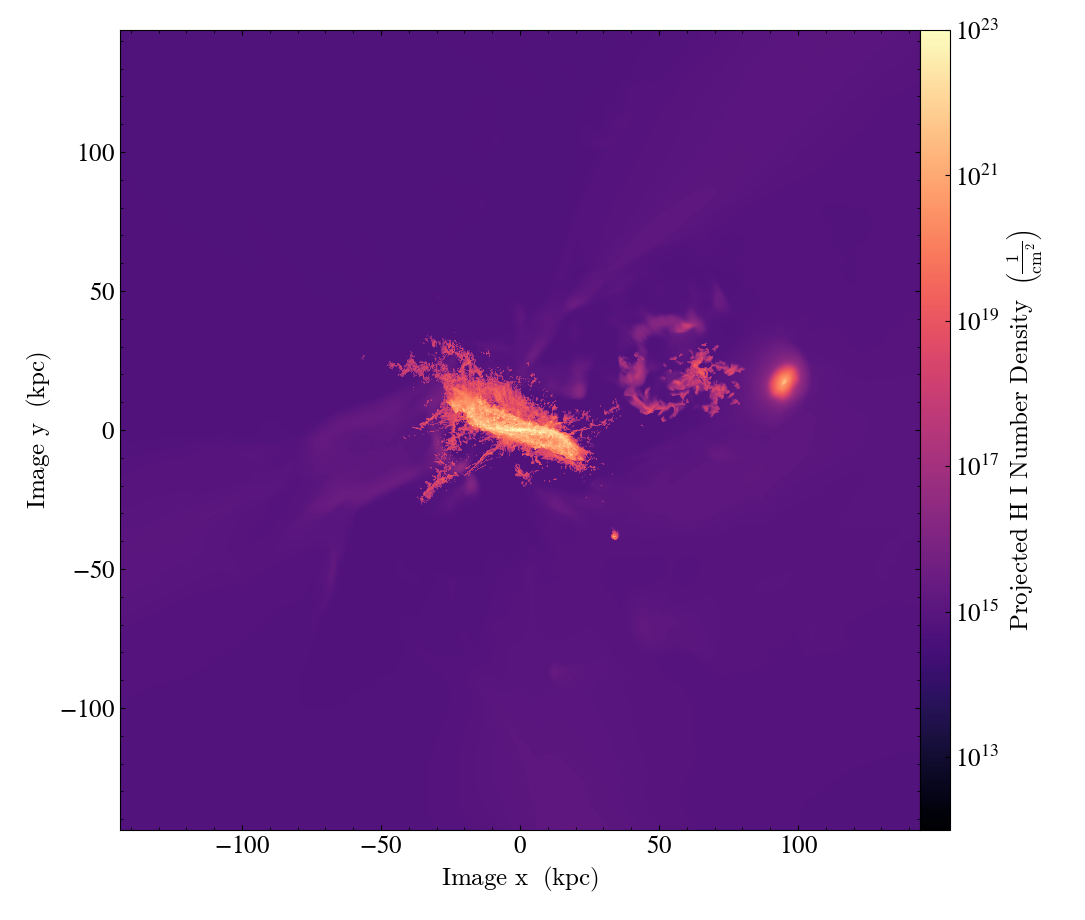

yt : [INFO     ] 2025-01-10 11:36:24,984 xlim = -0.001000 0.001000
yt : [INFO     ] 2025-01-10 11:36:24,985 ylim = -0.001000 0.001000
yt : [INFO     ] 2025-01-10 11:36:24,985 zlim = -0.500000 0.500000
yt : [INFO     ] 2025-01-10 11:36:24,985 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 800 by 800
yt : [INFO     ] 2025-01-10 11:36:45,566 Saving plot /Users/vidasaeedzadeh/Projects/foggie_outputs//ions_halo_008508/ludicrous/nref13c_nref9f.enhance/number_density_projections/face/H_I_face_number_density.png



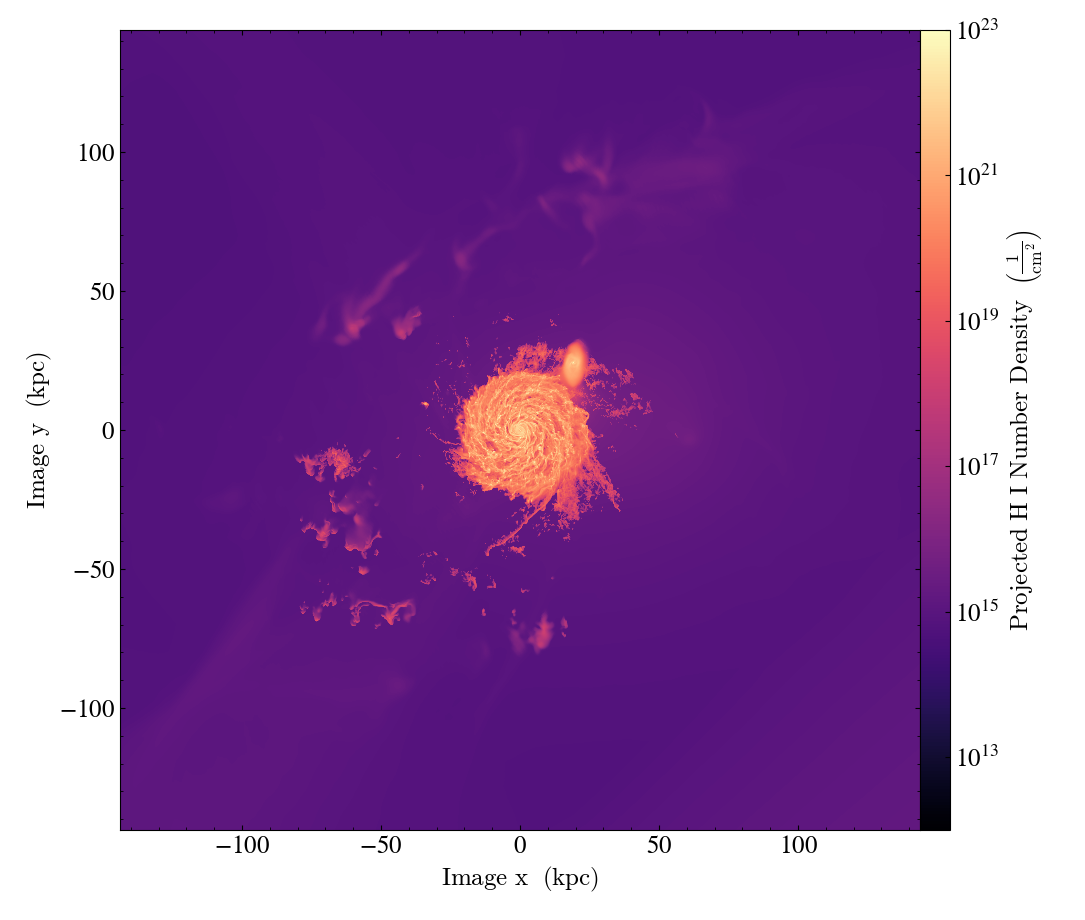

In [11]:
def projection_density(ds, ions, ions_density_dict, label_dict):
    """
    Create projection plots for the number density of specified ions.

    Parameters:
    -----------
    ds : yt.Dataset
        Loaded yt dataset.
    ions : list of str
        List of ion names for projection.
    save_path : str
        Directory where the plots will be saved.
    ions_density_dict : dict
        Dictionary mapping ions to their number density fields.
    label_dict : dict
        Dictionary mapping ions to their plot labels.

    Returns:
    --------
    None
    """
    for ion in ions:
        print(f"Generating projection plot for {ion}...")
        
        # Get the corresponding number density field for the ion
        density_field = ('gas', ions_density_dict[ion])
        print('ion',ions_density_dict[ion])


        ##Edge-on projection
        #Create the projection plot along the z-axis
        orientation = 'edge'
        proj_edge = yt.ProjectionPlot(ds, ds.x_unit_disk, ('gas', ions_density_dict[ion]), center=ds.halo_center_kpc, width=(ds.refine_width, 'kpc'),
                              north_vector=ds.z_unit_disk, method = 'integrate', weight_field=None) 
        #p.set_unit(density_field, 'cm**-3')
        proj_edge.set_cmap(density_field, 'magma')
        proj_edge.set_zlim(ions_density_dict[ion], zlim_dict[ion][0], zlim_dict[ion][1])
    
        #p.annotate_title(f"{label_dict.get(ion, ion)} Number Density")
        
        # Save the plot
        plot_dir = os.path.join(prefix, "number_density_projections", orientation)
        os.makedirs(plot_dir, exist_ok=True)
        proj_edge.save(os.path.join(plot_dir, f"{ion.replace(' ', '_')}_{orientation}_number_density.png"))
        proj_edge.show()

        # Face-on projection
        # Create the projection plot along the z-axis
        orientation = 'face'
        proj_face = yt.ProjectionPlot(ds, ds.z_unit_disk, ('gas', ions_density_dict[ion]), center=ds.halo_center_kpc, width=(ds.refine_width, 'kpc'),
                              north_vector=ds.x_unit_disk, method = 'integrate', weight_field=None) 
        #p.set_unit(density_field, 'cm**-3')
        proj_face.set_cmap(density_field, 'magma')
        proj_face.set_zlim(ions_density_dict[ion], zlim_dict[ion][0], zlim_dict[ion][1])
        #p.annotate_title(f"{label_dict.get(ion, ion)} Number Density")
        
        # Save the plot
        plot_dir = os.path.join(prefix, "number_density_projections", orientation)
        os.makedirs(plot_dir, exist_ok=True)
        proj_face.save(os.path.join(plot_dir, f"{ion.replace(' ', '_')}_{orientation}_number_density.png"))
        proj_face.show()

# Main workflow
ions_dict = {'H I':'H I', 'C III':'CIII_1910', 'C II': 'CII_1335',
                 'C IV':'CIV_1548','O VI':'OVI'}
ions_density_dict = {'H I':'H_p0_number_density', 'C III':'C_p2_number_density','C II':'C_p1_number_density',
                 'C IV':'C_p3_number_density','O VI':'O_p5_number_density'}
    
label_dict = {'Halpha':r'H$\alpha$', 'C III':'C III','C II':'C II',
                'C IV':'C IV','O VI':'O VI'}
zlim_dict = {'H I':[1e12,1e23], 'C III':[1e9,1e16],'C II':[1e7,1e19],
                 'C IV':[1e10,2e15], 'O VI':[1e10,3e14], 'Si III':[1e-22,1e16]}


def load_and_calculate(snap, ions):
    snap_name = foggie_dir + snap + '/' + snap
    
    # Load the dataset
    ds, refine_box = foggie_load(
        snap_name, 
        trackname, 
        do_filter_particles=True, 
        halo_c_v_name=halo_c_v_name, 
        disk_relative=True, 
        correct_bulk_velocity=True
    )

    # Add ion fields
    add_ion_fields(ds)
    add_ion_fields(ds)

    # Generate projection plots for the number density
    projection_density(ds, ions, ions_density_dict, label_dict)

# Run the analysis
load_and_calculate(snap, ions)





    

In [3]:
ds, refine_box = foggie_load(
        snap_name, 
        trackname, 
        do_filter_particles=True, 
        halo_c_v_name=halo_c_v_name, 
        disk_relative=True, 
        correct_bulk_velocity=True
    )

yt : [INFO     ] 2025-01-30 10:12:44,737 Parameters: current_time              = 639.44151531954
yt : [INFO     ] 2025-01-30 10:12:44,737 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-30 10:12:44,738 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-30 10:12:44,738 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-30 10:12:44,738 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-30 10:12:44,739 Parameters: current_redshift          = 5.0084873179923e-06
yt : [INFO     ] 2025-01-30 10:12:44,739 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2025-01-30 10:12:44,739 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2025-01-30 10:12:44,739 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-30 10:12:44,740 Parameters: hubble_constant           = 0.695


Opening snapshot /Users/vidasaeedzadeh/Projects/foggie_data/halo_008508/ludicrous/nref13c_nref9f.enhance/DD2520/DD2520
get_refine_box: using this location:         col1          col2     col3     col4    col5     col6     col7  col8
------------------- -------- -------- ------- -------- -------- ------- ----
4.4408920985006e-16 0.488865 0.470316 0.50854 0.490865 0.472316 0.51054    9


Parsing Hierarchy : 100%|██████████| 14215/14215 [00:00<00:00, 23588.77it/s]
yt : [INFO     ] 2025-01-30 10:12:45,547 Gathering a field list (this may take a moment.)


This halo_c_v file doesn't exist, calculating halo center...
get_halo_center: code_length code_velocity
get_halo_center: obtained the spherical region
get_halo_center: extracted the DM density
get_halo_center: we have obtained the preliminary center
got the velocities
get_halo_center: located the main halo at: [0.48985028266906744, 0.4711954593658448, 0.5095441341400146] [unyt_quantity(0.00155134, 'code_velocity'), unyt_quantity(-0.00169669, 'code_velocity'), unyt_quantity(0.00070822, 'code_velocity')]
filtering young_stars particles...
filtering young_stars3 particles...
filtering young_stars8 particles...
filtering old_stars particles...
filtering stars particles...
filtering dm particles...
using particle type  young_stars  to derive angular momentum
found angular momentum vector


In [4]:
ds.field_list

[('all', 'creation_time'),
 ('all', 'dynamical_time'),
 ('all', 'metallicity_fraction'),
 ('all', 'particle_index'),
 ('all', 'particle_mass'),
 ('all', 'particle_position_x'),
 ('all', 'particle_position_y'),
 ('all', 'particle_position_z'),
 ('all', 'particle_type'),
 ('all', 'particle_velocity_x'),
 ('all', 'particle_velocity_y'),
 ('all', 'particle_velocity_z'),
 ('enzo', 'Cooling_Time'),
 ('enzo', 'Dark_Matter_Density'),
 ('enzo', 'Density'),
 ('enzo', 'Electron_Density'),
 ('enzo', 'GasEnergy'),
 ('enzo', 'Grav_Potential'),
 ('enzo', 'HII_Density'),
 ('enzo', 'HI_Density'),
 ('enzo', 'HeIII_Density'),
 ('enzo', 'HeII_Density'),
 ('enzo', 'HeI_Density'),
 ('enzo', 'Metal_Density'),
 ('enzo', 'Temperature'),
 ('enzo', 'TotalEnergy'),
 ('enzo', 'x-velocity'),
 ('enzo', 'y-velocity'),
 ('enzo', 'z-velocity'),
 ('io', 'creation_time'),
 ('io', 'dynamical_time'),
 ('io', 'metallicity_fraction'),
 ('io', 'particle_index'),
 ('io', 'particle_mass'),
 ('io', 'particle_position_x'),
 ('io'

In [5]:
ds.derived_field_list

[('all', 'age'),
 ('all', 'creation_time'),
 ('all', 'dynamical_time'),
 ('all', 'mesh_id'),
 ('all', 'metallicity_fraction'),
 ('all', 'particle_angular_momentum'),
 ('all', 'particle_angular_momentum_magnitude'),
 ('all', 'particle_angular_momentum_x'),
 ('all', 'particle_angular_momentum_y'),
 ('all', 'particle_angular_momentum_z'),
 ('all', 'particle_index'),
 ('all', 'particle_mass'),
 ('all', 'particle_ones'),
 ('all', 'particle_position'),
 ('all', 'particle_position_cylindrical_radius'),
 ('all', 'particle_position_cylindrical_theta'),
 ('all', 'particle_position_cylindrical_z'),
 ('all', 'particle_position_relative_x'),
 ('all', 'particle_position_relative_y'),
 ('all', 'particle_position_relative_z'),
 ('all', 'particle_position_spherical_phi'),
 ('all', 'particle_position_spherical_radius'),
 ('all', 'particle_position_spherical_theta'),
 ('all', 'particle_position_x'),
 ('all', 'particle_position_y'),
 ('all', 'particle_position_z'),
 ('all', 'particle_radial_velocity'),
 (

In [13]:
[field for field in ds.derived_field_list if "gas" in field[0]]


[('gas', 'El_density'),
 ('gas', 'El_fraction'),
 ('gas', 'El_mass'),
 ('gas', 'El_number_density'),
 ('gas', 'H_density'),
 ('gas', 'H_fraction'),
 ('gas', 'H_mass'),
 ('gas', 'H_nuclei_density'),
 ('gas', 'H_number_density'),
 ('gas', 'H_p0_density'),
 ('gas', 'H_p0_fraction'),
 ('gas', 'H_p0_mass'),
 ('gas', 'H_p0_number_density'),
 ('gas', 'H_p1_density'),
 ('gas', 'H_p1_fraction'),
 ('gas', 'H_p1_mass'),
 ('gas', 'H_p1_number_density'),
 ('gas', 'He_density'),
 ('gas', 'He_fraction'),
 ('gas', 'He_mass'),
 ('gas', 'He_nuclei_density'),
 ('gas', 'He_number_density'),
 ('gas', 'He_p0_density'),
 ('gas', 'He_p0_fraction'),
 ('gas', 'He_p0_mass'),
 ('gas', 'He_p0_number_density'),
 ('gas', 'He_p1_density'),
 ('gas', 'He_p1_fraction'),
 ('gas', 'He_p1_mass'),
 ('gas', 'He_p1_number_density'),
 ('gas', 'He_p2_density'),
 ('gas', 'He_p2_fraction'),
 ('gas', 'He_p2_mass'),
 ('gas', 'He_p2_number_density'),
 ('gas', 'angular_momentum_magnitude'),
 ('gas', 'angular_momentum_x'),
 ('gas', 'a

In [20]:
ad[("gas", "velocity_los")]


NeedsParameter: (['axis'])

In [21]:
# Define projection axis (0 = x, 1 = y, 2 = z)
axis = 2  # Change this to the desired LOS axis (2 for face-on, 0 or 1 for edge-on)

# Project the LOS velocity field
proj = ds.proj(("gas", "velocity_los"), axis)

# Convert to physical units
vel_los = proj.to_frb(width=(100, "kpc"), resolution=512)[("gas", "velocity_los")]

# Print mean velocity
print("Mean velocity_los along axis {}: {:.2f} km/s".format(axis, vel_los.mean()))



yt : [INFO     ] 2025-01-30 10:35:26,164 Projection completed
yt : [INFO     ] 2025-01-30 10:35:26,165 Making a fixed resolution buffer of (('gas', 'velocity_los')) 512 by 512


Mean velocity_los along axis 2: 6593566973451599245365211037696.00 cm**2/s km/s


In [22]:
print("Disk-relative unit vectors:")
print("X_disk:", ds.x_unit_disk)
print("Y_disk:", ds.y_unit_disk)
print("Z_disk (should be aligned with angular momentum):", ds.z_unit_disk)


Disk-relative unit vectors:
X_disk: [-0.59228031  0.62007721 -0.51449809] dimensionless
Y_disk: [ 0.72993836  0.14255567 -0.66848177] dimensionless
Z_disk (should be aligned with angular momentum): [-0.34116569 -0.77148048 -0.53705106] dimensionless
